<a href="https://colab.research.google.com/github/marlungu/gwu_rml/blob/main/assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install interpret
from interpret.glassbox import ExplainableBoostingClassifier  # interpret ebm class
from interpret.perf import ROC                                # ROC measure for ebm
import itertools                                              # for cartesian product of parameters
import matplotlib.pyplot as plt                               # for plots
import numpy as np                                            # for basic array manipulation
import pandas as pd                                           # for dataframe manipulation
import random                                                 # to sample from lists
from sklearn.metrics import accuracy_score, f1_score          # for selecting model cutoffs
import time                                                   # for timers

# set numpy random seed for better reproducibility
SEED = 12345
np.random.seed(SEED)

# set number of threads
NTHREAD = 4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Define utility functions
## Utility function to calculate confusion matrices by demographic group

In [12]:
def get_confusion_matrix(frame, y, yhat, by=None, level=None, cutoff=0.5, verbose=True):

    """ Creates confusion matrix from pandas dataframe of y and yhat values, can be sliced
        by a variable and level.

        :param frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        :param y: Name of actual value column.
        :param yhat: Name of predicted value column.
        :param by: By variable to slice frame before creating confusion matrix, default None.
        :param level: Value of by variable to slice frame before creating confusion matrix, default None.
        :param cutoff: Cutoff threshold for confusion matrix, default 0.5.
        :param verbose: Whether to print confusion matrix titles, default True.
        :return: Confusion matrix as pandas dataframe.

    """

    # determine levels of target (y) variable
    # sort for consistency
    level_list = list(frame[y].unique())
    level_list.sort(reverse=True)

    # init confusion matrix
    cm_frame = pd.DataFrame(columns=['actual: ' +  str(i) for i in level_list],
                            index=['predicted: ' + str(i) for i in level_list])

    # don't destroy original data
    frame_ = frame.copy(deep=True)

    # convert numeric predictions to binary decisions using cutoff
    dname = 'd_' + str(y)
    frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)

    # slice frame
    if (by is not None) & (level is not None):
        frame_ = frame_[frame[by] == level]

    # calculate size of each confusion matrix value
    for i, lev_i in enumerate(level_list):
        for j, lev_j in enumerate(level_list):
            cm_frame.iat[j, i] = frame_[(frame_[y] == lev_i) & (frame_[dname] == lev_j)].shape[0]
            # i, j vs. j, i nasty little bug ... updated 8/30/19

    # output results
    if verbose:
        if by is None:
            print('Confusion matrix:')
        else:
            print('Confusion matrix by ' + by + '=' + str(level))

    return cm_frame

In [13]:
def air(cm_dict, reference_key, protected_key, verbose=True):

    """ Calculates the adverse impact ratio as a quotient between protected and
        reference group acceptance rates: protected_prop/reference_prop.
        Optionally prints intermediate values. ASSUMES 0 IS "POSITIVE" OUTCOME!

        :param cm_dict: Dictionary of demographic group confusion matrices.
        :param reference_key: Name of reference group in cm_dict as a string.
        :param protected_key: Name of protected group in cm_dict as a string.
        :param verbose: Whether to print intermediate acceptance rates, default True.
        :return: AIR.

    """

    eps = 1e-20 # numeric stability and divide by 0 protection

    # reference group summary
    reference_accepted = float(cm_dict[reference_key].iat[1,0] + cm_dict[reference_key].iat[1,1]) # predicted 0's
    reference_total = float(cm_dict[reference_key].sum().sum())
    reference_prop = reference_accepted/reference_total
    if verbose:
        print(reference_key.title() + ' proportion accepted: %.3f' % reference_prop)

    # protected group summary
    protected_accepted = float(cm_dict[protected_key].iat[1,0] + cm_dict[protected_key].iat[1,1]) # predicted 0's
    protected_total = float(cm_dict[protected_key].sum().sum())
    protected_prop = protected_accepted/protected_total
    if verbose:
        print(protected_key.title() + ' proportion accepted: %.3f' % protected_prop)

    # return adverse impact ratio
    if np.isclose(protected_accepted, 0.0):
        return np.nan
    else:
        return ((protected_prop + eps)/(reference_prop + eps))

In [14]:
def get_max_f1_frame(frame, y, yhat, res=0.01, air_reference=None, air_protected=None, verbose=False):

    """ Utility function for finding max. F1.
        Coupled to get_confusion_matrix() and air().
        Assumes 1 is the marker for class membership.

        :param frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        :param y: Known y values.
        :param yhat: Model scores.
        :param res: Resolution over which to search for max. F1, default 0.01.
        :param air_reference: Reference group for AIR calculation, optional.
        :param air_protected: Protected group for AIR calculation, optional.
        :return: Pandas DataFrame of cutoffs to select from.

    """

    do_air = all(v is not None for v in [air_reference, air_protected])

    # init frame to store f1 at different cutoffs
    if do_air:
        columns = ['cut', 'f1', 'acc', 'air']
    else:
        columns = ['cut', 'f1', 'acc']
    f1_frame = pd.DataFrame(columns=['cut', 'f1', 'acc'])

    # copy known y and score values into a temporary frame
    temp_df = frame[[y, yhat]].copy(deep=True)

    # find f1 at different cutoffs and store in acc_frame
    for cut in np.arange(0, 1 + res, res):
        temp_df['decision'] = np.where(temp_df.iloc[:, 1] > cut, 1, 0)
        f1 = f1_score(temp_df.iloc[:, 0], temp_df['decision'])
        acc = accuracy_score(temp_df.iloc[:, 0], temp_df['decision'])
        row_dict = {'cut': cut, 'f1': f1, 'acc': acc}
        if do_air:
            # conditionally calculate AIR
            cm_ref = get_confusion_matrix(frame, y, yhat, by=air_reference, level=1, cutoff=cut, verbose=verbose)
            cm_pro = get_confusion_matrix(frame, y, yhat, by=air_protected, level=1, cutoff=cut, verbose=verbose)
            air_ = air({air_reference: cm_ref, air_protected: cm_pro}, air_reference, air_protected, verbose=verbose)
            row_dict['air'] = air_

        f1_frame = f1_frame.append(row_dict, ignore_index=True)

    del temp_df

    return f1_frame

In [15]:
def ebm_grid(train, valid, x_names, y_name, gs_params=None, n_models=None, early_stopping_rounds=None, seed=None,
             air_reference=None, air_protected=None, air_cut=None, verbose=False):

    """ Performs a random grid search over n_models and gs_params.
        Optionally considers random feature sets and AIR.
        Coupled to get_confusion_matrix() and air().

    :param train: Training data as Pandas DataFrame.
    :param valid: Validation data as Pandas DataFrame.
    :param x_names: Names of input features.
    :param y_name: Name of target feature.
    :param gs_params: Dictionary of lists of potential EBM parameters over which to search.
    :param n_models: Number of random models to evaluate.
    :param early_stopping_rounds: EBM early stopping rounds.
    :param seed: Random seed for better interpretability.
    :param air_reference: Reference group for AIR calculation, optional.
    :param air_protected: Protected group for AIR calculation, optional.
    :param air_cut: Cutoff for AIR calculation, optional.
    :param verbose: Whether to print intermediate acceptance rates, default False.
    :return: Tuple: (Best EBM model, Pandas DataFrame of models to select from)

    """

    # init returned frame
    do_air = all(v is not None for v in [air_reference, air_protected])
    if do_air:
        columns = list(gs_params.keys()) + ['features', 'auc', 'air']
    else:
        columns = list(gs_params.keys()) + ['auc']
    ebm_grid_frame = pd.DataFrame(columns=columns)

    # cartesian product of gs_params
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # preserve exact reproducibility for this function
    np.random.seed(SEED)

    # select randomly from cartesian product space
    selected_experiments = np.random.choice(len(experiments), n_models)

    # set global params for seed, etc.
    params = {'n_jobs': NTHREAD,
              'early_stopping_rounds': early_stopping_rounds,
              'random_state': SEED}

    # init grid search loop
    best_candidate = None
    best_score = 0

    # grid search loop
    for i, exp in enumerate(selected_experiments):

        params.update(experiments[exp])  # override global params with current grid run params

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)

        # train
        ebm = ExplainableBoostingClassifier(**params)

        # conditionally select random features
        features = x_names
        if do_air:
            n_features = random.randrange(len(x_names)) + 1
            features = random.sample(x_names, n_features)
        candidate = ebm.fit(train[features], train[y_name])

        # calculate AUC
        ebm_perf = ROC(ebm.predict_proba).explain_perf(valid[features], valid[y_name])
        candidate_best_score = ebm_perf._internal_obj['overall']['auc']

        # compose values to add to ebm_grid_frame
        row_dict = params.copy()
        row_dict['auc'] = candidate_best_score
        if do_air:
            # collect random feature set
            row_dict['features'] = features
            # conditionally calculate AIR
            valid_phat = valid.copy(deep=True)
            valid_phat['phat'] = candidate.predict_proba(valid[features])[:, 1]
            cm_ref = get_confusion_matrix(valid_phat, y_name, 'phat', by=air_reference, level=1, cutoff=air_cut, verbose=verbose)
            cm_pro = get_confusion_matrix(valid_phat, y_name, 'phat', by=air_protected, level=1, cutoff=air_cut, verbose=verbose)
            air_ = air({air_reference: cm_ref, air_protected: cm_pro}, air_reference, air_protected, verbose=verbose)
            row_dict['air'] = air_
            del valid_phat

        # append run to ebm_grid_frame
        ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)

        # determine if current model is better than previous best
        if candidate_best_score > best_score:
            best_score = candidate_best_score
            best_ebm = candidate
            print('Grid search new best score discovered at iteration %d/%d: %.4f.' %
                             (int(i + 1), int(n_models), candidate_best_score))

        print('---------- ----------')

        del row_dict
        del ebm

    return best_ebm, ebm_grid_frame


In [16]:
tic = time.time()


**IMPORT DATA**


In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
data = pd.read_csv('/content/drive/MyDrive/RML/hmda_train_preprocessed.csv')
test = pd.read_csv('/content/drive/MyDrive/RML/hmda_test_preprocessed.csv')


**Assign basic modeling roles**

In [20]:
y_name = 'high_priced'
x_names = ['term_360', 'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std', 'loan_to_value_ratio_std', 'no_intro_rate_period_std',
           'intro_rate_period_std', 'property_value_std', 'income_std', 'debt_to_income_ratio_std']

# **Fit interpretable model**

## Split data into train and validation partitions

In [21]:
np.random.seed(SEED) # preserve exact reproducibility for this cell

split_ratio = 0.7 # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

# benchmark - Train data rows = 112253, columns = 23
# benchmark - Validation data rows = 48085, columns = 23

Train data rows = 112253, columns = 23
Validation data rows = 48085, columns = 23


# **Explainable Boosting Machine**
## Fit EBM with random grid search

In [22]:
# dictionary of hyperparameter value lists for grid search
gs_params = {'max_bins': [128, 256, 512],
             'max_interaction_bins': [16, 32, 64],
             'interactions': [5, 10, 15],
             'outer_bags': [4, 8, 12],
             'inner_bags': [0, 4],
             'learning_rate': [0.001, 0.01, 0.05],
             'validation_size': [0.1, 0.25, 0.5],
             'min_samples_leaf': [1, 2, 5, 10],
             'max_leaves': [1, 3, 5]}

# start local timer
ebm_tic = time.time()

# EBM grid search
best_ebm, ebm_grid_frame = ebm_grid(train, valid, x_names, y_name, gs_params=gs_params, n_models=10,
                                    early_stopping_rounds=100, seed=SEED)

# end local timer
ebm_toc = time.time() - ebm_tic
print('EBM training completed in %.2f s.' % (ebm_toc))

Grid search run 1/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


Grid search new best score discovered at iteration 1/10: 0.8218.
---------- ----------
Grid search run 2/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 3/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 4/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 5/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


Grid search new best score discovered at iteration 5/10: 0.8253.
---------- ----------
Grid search run 6/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 7/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 10, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 8/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 9/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 10/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 3}
---------- ----------
EBM training completed in 446.18 s.


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


## Basic AUC assessment

In [ ]:
best_ebm_perf = ROC(best_ebm.predict_proba).explain_perf(valid[x_names], valid[y_name])
print('Validation AUC: %.4f.' % best_ebm_perf._internal_obj['overall']['auc'])

Validation AUC: 0.8253.


## Score validation data with model

In [23]:
best_ebm_phat = pd.DataFrame(best_ebm.predict_proba(valid[x_names])[:, 1], columns=['phat'])
best_ebm_phat = pd.concat([valid.reset_index(drop=True), best_ebm_phat], axis=1)
best_ebm_phat.head()


,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,...,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.040307,0.854601,0,0.165646
1,6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.020904,1.037419,0,0.314594
2,8,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,0.277109,0.142995,0.244394,-0.215304,0.111598,-0.019865,0.031916,0,0.022284
3,10,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,-0.382476,-0.240432,0.244394,-0.215304,-0.320089,-0.028181,0.946010,0,0.015600
4,11,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,0,0.101220,-0.266529,0.244394,-0.215304,0.111598,0.016515,-1.156406,0,0.004888


#Investigate Best Model (EBM) for Discrimination
##Find optimal cutoff based on F1
Cutoffs are normally selected by maximizing a quality statistic or a business metric, and not by considering bias and discrimination.



In [24]:
f1_frame = get_max_f1_frame(best_ebm_phat, y_name, 'phat')

print(f1_frame)
print()

max_f1 = f1_frame['f1'].max()
best_cut = f1_frame.loc[int(f1_frame['f1'].idxmax()), 'cut'] #idxmax() returns the index of the maximum value
acc = f1_frame.loc[int(f1_frame['f1'].idxmax()), 'acc']

print('Best EBM F1: %.4f achieved at cutoff: %.2f with accuracy: %.4f.' % (max_f1, best_cut, acc))

<ipython-input-14-0024592946e0>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_frame = f1_frame.append(row_dict, ignore_index=True)
<ipython-input-14-0024592946e0>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_frame = f1_frame.append(row_dict, ignore_index=True)
<ipython-input-14-0024592946e0>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_frame = f1_frame.append(row_dict, ignore_index=True)
<ipython-input-14-0024592946e0>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_frame = f1_frame.append(row_dict, ignore_index=True)
<ipython-input-14-0024592946e0>:42: FutureWarning: The frame.append method is deprecated and

      cut        f1       acc
0    0.00  0.173860  0.095206
1    0.01  0.233938  0.384777
2    0.02  0.262541  0.479048
3    0.03  0.280733  0.530685
4    0.04  0.295953  0.569783
..    ...       ...       ...
96   0.96  0.000000  0.904794
97   0.97  0.000000  0.904794
98   0.98  0.000000  0.904794
99   0.99  0.000000  0.904794
100  1.00  0.000000  0.904794

[101 rows x 3 columns]

Best EBM F1: 0.3666 achieved at cutoff: 0.18 with accuracy: 0.7927.


<ipython-input-14-0024592946e0>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_frame = f1_frame.append(row_dict, ignore_index=True)
<ipython-input-14-0024592946e0>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_frame = f1_frame.append(row_dict, ignore_index=True)
<ipython-input-14-0024592946e0>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_frame = f1_frame.append(row_dict, ignore_index=True)
<ipython-input-14-0024592946e0>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_frame = f1_frame.append(row_dict, ignore_index=True)
<ipython-input-14-0024592946e0>:42: FutureWarning: The frame.append method is deprecated and

## Find confusion matrices for demographic groups

In [25]:
demographic_group_names = ['black', 'asian', 'white', 'male', 'female']
cm_dict = {}

for name in demographic_group_names:
    cm_dict[name] = get_confusion_matrix(best_ebm_phat, y_name, 'phat', by=name, level=1, cutoff=best_cut)
    print(cm_dict[name])
    print()

Confusion matrix by black=1
             actual: 1 actual: 0
predicted: 1       470       911
predicted: 0       194      1617

Confusion matrix by asian=1
             actual: 1 actual: 0
predicted: 1        95       176
predicted: 0        53      2926

Confusion matrix by white=1
             actual: 1 actual: 0
predicted: 1      1965      6117
predicted: 0      1200     25243

Confusion matrix by male=1
             actual: 1 actual: 0
predicted: 1      1036      3122
predicted: 0       628     11046

Confusion matrix by female=1
             actual: 1 actual: 0
predicted: 1       847      2175
predicted: 0       393      6617



## Find AIR for Asian people

In [26]:
print('Adverse impact ratio for Asian people vs. White people: %.3f' % air(cm_dict, 'white', 'asian'))

White proportion accepted: 0.766
Asian proportion accepted: 0.917
Adverse impact ratio for Asian people vs. White people: 1.197


## Find AIR for Black people

In [27]:
print('Adverse impact ratio for Black people vs. White people: %.3f' % air(cm_dict, 'white', 'black'))

White proportion accepted: 0.766
Black proportion accepted: 0.567
Adverse impact ratio for Black people vs. White people: 0.741


## Find AIR for Females

In [28]:
print('Adverse impact ratio for Females vs. Males: %.3f' % air(cm_dict, 'male', 'female'))

Male proportion accepted: 0.737
Female proportion accepted: 0.699
Adverse impact ratio for Females vs. Males: 0.948


# Attempt remediation of discovered discrimination
## Simplest remediation: Find cutoff with better Black vs. White AIR

In [29]:
f1_frame = get_max_f1_frame(best_ebm_phat, y_name, 'phat', air_reference='white', air_protected='black')
# print highest quality cutoffs above four fifths rule cutoff
f1_frame[f1_frame['air'] > 0.8].sort_values(by='f1', ascending=False).head()

<ipython-input-14-0024592946e0>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_frame = f1_frame.append(row_dict, ignore_index=True)
<ipython-input-14-0024592946e0>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_frame = f1_frame.append(row_dict, ignore_index=True)
<ipython-input-14-0024592946e0>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_frame = f1_frame.append(row_dict, ignore_index=True)
<ipython-input-14-0024592946e0>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f1_frame = f1_frame.append(row_dict, ignore_index=True)
<ipython-input-14-0024592946e0>:42: FutureWarning: The frame.append method is deprecated and

,cut,f1,acc,air
22,0.22,0.356794,0.832942,0.816260
23,0.23,0.350179,0.841156,0.843019
24,0.24,0.341709,0.850161,0.864101
25,0.25,0.330154,0.858313,0.878680
26,0.26,0.316466,0.865155,0.887407


Cutoffs in the 0.22-0.26 range provide increased accuracy and less bias towards Black people.



## Check that other groups are not adversely impacted by change

In [30]:
# calculate new confusion matrics for each group
rem_cm_dict = {}
for name in demographic_group_names:
    rem_cm_dict[name] = get_confusion_matrix(best_ebm_phat, y_name, 'phat', by=name, level=1, cutoff=0.22, verbose=False)

# calculate AIR for each group
print('Adverse impact ratio for Asian people vs. White people: %.3f' % air(rem_cm_dict, 'white', 'asian', verbose=False))
print('Adverse impact ratio for Black people vs. White people: %.3f' % air(rem_cm_dict, 'white', 'black', verbose=False))
print('Adverse impact ratio for Females vs. Males: %.3f' % air(rem_cm_dict, 'male', 'female', verbose=False))

Adverse impact ratio for Asian people vs. White people: 1.128
Adverse impact ratio for Black people vs. White people: 0.816
Adverse impact ratio for Females vs. Males: 0.965


The new cutoff does not adversely affect other protected groups.



## More sophisticated remdiation: Model selection via quality and fairness

In [31]:
# start local timer
ebm2_tic = time.time()

# new grid search that also considers AIR and fairness
best_ebm2, ebm_grid_frame = ebm_grid(train, best_ebm_phat, x_names, y_name, gs_params=gs_params, n_models=500,
                                     early_stopping_rounds=100, seed=SEED, air_reference='white', air_protected='black',
                                     air_cut=0.17)

# end local timer
ebm2_toc = time.time() - ebm2_tic
print('EBM training completed in %.2f s.' % (ebm2_toc))

Grid search run 1/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


Grid search new best score discovered at iteration 1/500: 0.7848.
---------- ----------
Grid search run 2/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 3/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


Grid search new best score discovered at iteration 3/500: 0.8170.
---------- ----------
Grid search run 4/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 5/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


Grid search new best score discovered at iteration 5/500: 0.8256.
---------- ----------
Grid search run 6/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 7/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 10, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 8/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 9/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 10/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 11/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 1, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 12/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 13/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 14/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 15/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 16/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 10, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 17/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 18/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 19/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 20/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 10, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 21/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 22/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 23/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 24/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 25/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 26/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 27/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 10, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 28/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 10, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 29/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 10, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 30/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 10, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 31/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 32/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 33/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 10, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 34/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 35/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 36/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 37/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 38/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 39/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 40/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 10, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 41/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 42/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 43/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 10, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 44/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 45/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 10, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 46/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 10, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 47/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 1, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 48/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 49/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 50/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 1, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 51/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 52/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 53/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 54/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 55/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 56/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 57/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 58/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 59/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 60/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 10, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 61/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 62/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 63/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 64/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 65/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 66/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 67/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 68/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 1, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 69/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 1, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 70/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 10, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 71/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 72/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 73/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 74/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 75/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 76/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 77/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 78/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 79/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 80/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 81/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 82/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 83/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 84/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 1, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 85/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 10, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 86/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 87/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 88/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 89/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 10, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 90/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 1, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 91/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 10, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 92/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 93/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 94/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 95/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 96/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 97/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 98/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 99/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 100/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 101/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 102/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 103/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 104/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 1, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 105/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 106/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 107/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 108/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 1, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 109/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 110/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 111/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 112/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 113/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 114/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 115/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 116/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 117/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 118/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 119/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 120/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 121/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 10, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 122/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 123/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 124/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 125/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 126/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 127/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 128/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 129/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 130/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 131/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 132/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 133/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 134/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 135/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 136/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 10, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 137/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 138/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 139/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 140/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 141/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 142/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 10, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 143/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 144/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 145/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 1, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 146/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 147/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 148/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 149/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 10, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 150/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 151/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 152/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 1, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 153/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 154/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 155/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 1, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 156/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 157/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 158/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 159/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 160/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 161/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 162/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 163/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 164/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 165/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 166/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 167/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 168/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 169/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 170/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 1, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 171/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 172/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 173/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 174/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 175/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 176/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 177/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 178/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 179/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 180/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 181/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 182/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 183/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 10, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 184/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 185/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 186/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 187/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 188/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 10, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 189/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 190/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 1, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 191/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 192/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 193/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 194/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 10, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 195/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 10, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 196/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 1, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 197/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 198/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 199/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 200/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 201/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 10, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 202/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 203/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 204/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 205/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 1, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 206/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 207/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 208/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 209/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 210/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 10, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 211/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 212/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 213/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 10, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 214/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 215/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 216/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 10, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 217/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 218/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 219/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 220/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 221/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 222/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 10, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 223/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 224/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 225/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 226/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 227/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 228/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 10, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 229/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 10, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 230/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 231/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 232/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 233/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 234/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 235/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 1, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 236/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 237/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 238/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 239/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 240/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 241/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 10, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 242/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 243/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 244/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 245/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 10, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 246/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 247/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 248/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 249/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 250/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 251/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 10, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 252/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 253/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 1, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 254/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 255/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 10, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 256/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 257/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 10, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 258/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 259/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 260/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 10, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 261/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 262/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 263/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 264/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 265/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 266/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 267/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 268/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 269/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 1, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 270/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 271/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 10, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 272/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 273/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 10, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 274/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 275/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 10, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 276/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 277/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 278/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 279/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 280/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 281/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 10, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 282/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 283/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 284/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 285/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 286/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 287/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 288/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 289/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 290/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 291/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 292/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 293/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 1, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 294/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 295/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 1, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 296/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 297/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 10, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 298/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 299/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 300/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 301/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 302/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 10, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 303/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 304/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 305/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 306/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 307/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 308/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 309/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 310/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 311/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 312/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 313/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 314/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 1, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 315/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 316/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 317/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 318/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 319/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 320/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 1, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 321/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 322/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 1, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 323/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 324/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 10, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 325/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 326/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 327/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 328/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 329/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 330/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 10, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 331/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 332/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 333/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 334/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 335/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 336/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 337/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 338/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 339/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 340/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 341/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 342/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 10, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 343/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 344/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 10, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 345/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 346/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 347/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 348/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 10, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 349/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 350/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 351/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 352/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 353/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 354/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 355/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 356/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 357/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 1, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 358/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 1, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 359/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 360/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 361/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 362/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 363/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 364/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 365/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 366/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 367/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 368/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 369/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 370/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 371/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 372/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 373/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 10, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 374/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 375/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 376/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 10, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 377/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 378/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 379/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 380/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 381/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 382/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 383/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 384/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 385/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 10, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 386/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 1, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 387/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 10, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 388/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 389/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 390/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 391/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 10, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 392/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 393/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 394/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 395/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 396/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 397/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 398/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 399/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 400/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 401/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 402/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 403/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 10, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 404/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 1, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 405/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 406/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 407/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 408/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 409/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 410/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 411/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 10, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 412/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 413/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 414/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 415/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 416/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 417/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 418/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 419/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 420/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 1, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 421/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 422/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 10, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 423/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 10, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 424/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 425/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 426/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 427/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 428/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 429/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 430/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 1, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 431/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 432/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 433/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 434/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 435/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 436/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 10, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 437/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 10, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 438/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 439/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 440/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 441/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 10, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 442/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 443/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 444/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 445/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 10, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 446/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 447/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 448/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 449/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 450/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 451/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 452/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 453/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 454/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 10, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 455/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 456/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 457/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 458/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 459/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 460/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 461/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 462/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 1, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 463/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 464/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 1, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 465/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 466/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 467/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 468/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 469/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 470/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 1, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 471/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 472/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 10, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 473/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 10, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 474/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 475/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 476/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 477/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 478/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 479/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 480/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 481/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 482/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 483/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 484/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 485/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 486/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 487/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 488/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 1, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 489/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 490/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 491/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 10, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 492/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 493/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 494/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 495/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 5}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 496/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 10, 'max_leaves': 1}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 497/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 498/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 499/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 10, 'max_leaves': 3}


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


---------- ----------
Grid search run 500/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 3}
---------- ----------
EBM training completed in 14242.80 s.


<ipython-input-15-8c1f4a7a5d08>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)


## Display grid search results as table

In [32]:
ebm_grid_frame

,max_bins,max_interaction_bins,interactions,outer_bags,inner_bags,learning_rate,validation_size,min_samples_leaf,max_leaves,features,auc,air,n_jobs,early_stopping_rounds,random_state
0,512,16,5,4,0,0.050,0.25,1,3,"[income_std, property_value_std, loan_to_value...",0.784827,0.676379,4.0,100.0,12345.0
1,128,32,5,8,0,0.001,0.25,2,5,"[conforming, loan_to_value_ratio_std]",0.751711,0.741860,4.0,100.0,12345.0
2,512,16,5,4,0,0.001,0.50,1,3,"[intro_rate_period_std, loan_to_value_ratio_st...",0.816969,0.727576,4.0,100.0,12345.0
3,128,64,5,4,4,0.050,0.50,1,5,"[term_360, loan_amount_std]",0.676516,0.982547,4.0,100.0,12345.0
4,512,64,15,4,0,0.050,0.10,10,3,"[intro_rate_period_std, loan_to_value_ratio_st...",0.825551,0.720516,4.0,100.0,12345.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,256,32,5,8,4,0.010,0.50,10,1,"[term_360, no_intro_rate_period_std, property_...",0.500000,1.000000,4.0,100.0,12345.0
496,512,32,15,8,4,0.001,0.10,10,3,"[debt_to_income_ratio_std, loan_to_value_ratio...",0.804768,0.725850,4.0,100.0,12345.0
497,256,16,15,12,0,0.050,0.25,5,3,"[debt_to_income_ratio_std, debt_to_income_rati...",0.626639,0.897869,4.0,100.0,12345.0
498,128,64,10,12,0,0.001,0.50,10,3,"[term_360, no_intro_rate_period_std, income_st...",0.820238,0.726800,4.0,100.0,12345.0


## Display grid search results as plot

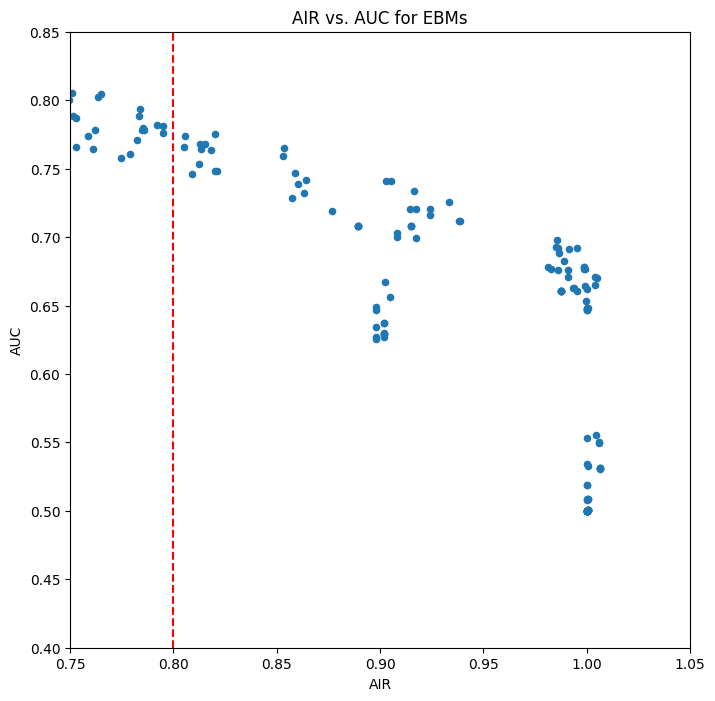

In [33]:
fig, ax = plt.subplots(figsize=(8,8))
_ = ebm_grid_frame.plot(kind='scatter', x='air', y='auc', title='AIR vs. AUC for EBMs', ax=ax)
_ = ax.axvline(x=0.8, color='r', linestyle='--')
_ = ax.set_ylim([0.4, 0.85])
_ = ax.set_xlim([0.75, 1.05])
_ = ax.set_xlabel('AIR')
_ = ax.set_ylabel('AUC')

## Retrain most accurate model above 0.8 AIR

In [34]:
# extract new params dict from ebm_grid_frame
rem_params = ebm_grid_frame.loc[ebm_grid_frame['air'] > 0.8].sort_values(by='auc', ascending=False).iloc[0, :].to_dict()

# extract features from dict then delete from dict
rem_x_names = rem_params['features']
del rem_params['features']

# record and delete other extraneous information
print('Best AUC: %.4f above 0.8 AIR (%.4f).' % (rem_params['auc'], rem_params['air']))
del rem_params['auc']
del rem_params['air']

# reset some parameters to integers
rem_params['random_state'] = int(rem_params['random_state'])
rem_params['n_jobs'] = int(rem_params['n_jobs'])

# retrain
rem_ebm = ExplainableBoostingClassifier(**rem_params)
rem_ebm.fit(train[rem_x_names], train[y_name])
rem_ebm_perf = ROC(rem_ebm.predict_proba).explain_perf(valid[rem_x_names], valid[y_name])
rem_auc = rem_ebm_perf._internal_obj['overall']['auc']
print('Remediated EBM retrained with AUC: %.4f.' % rem_auc)

Best AUC: 0.7756 above 0.8 AIR (0.8201).
Remediated EBM retrained with AUC: 0.7756.


## Check that other groups are not adversely impacted by change

In [35]:
# create a frame with remediated EBM predictions
best_ebm_phat2 = pd.DataFrame(rem_ebm.predict_proba(valid[rem_x_names])[:, 1], columns=['phat'])
best_ebm_phat2 = pd.concat([valid.reset_index(drop=True), best_ebm_phat2], axis=1)

# calculate new confusion matrices for each group
rem_cm_dict2 = {}
for name in demographic_group_names:
    rem_cm_dict2[name] = get_confusion_matrix(best_ebm_phat2, y_name, 'phat', by=name, level=1, cutoff=0.17, verbose=False)

# calculate AIR for each group
print('Adverse impact ratio for Asian people vs. White people: %.3f' % air(rem_cm_dict2, 'white', 'asian', verbose=False))
print('Adverse impact ratio for Black people vs. White people: %.3f' % air(rem_cm_dict2, 'white', 'black', verbose=False))
print('Adverse impact ratio for Females vs. Males: %.3f' % air(rem_cm_dict2, 'male', 'female', verbose=False))

Adverse impact ratio for Asian people vs. White people: 1.135
Adverse impact ratio for Black people vs. White people: 0.820
Adverse impact ratio for Females vs. Males: 0.956


This analysis shows that even with a selective cutoff of 0.17, less discriminatory models are available. The new set of features and hyperparameters leads to a ~13% increase in AIR with a ~5% decrease in AUC.

# Print best model parameters for later use

In [36]:
rem_params

{'max_bins': 256,
 'max_interaction_bins': 64,
 'interactions': 5,
 'outer_bags': 4,
 'inner_bags': 4,
 'learning_rate': 0.001,
 'validation_size': 0.1,
 'min_samples_leaf': 5,
 'max_leaves': 3,
 'n_jobs': 4,
 'early_stopping_rounds': 100.0,
 'random_state': 12345}

## Print best model features for later use

In [37]:
rem_x_names

['debt_to_income_ratio_std',
 'conforming',
 'intro_rate_period_std',
 'term_360',
 'no_intro_rate_period_std',
 'debt_to_income_ratio_missing',
 'income_std',
 'property_value_std']

## End timer

In [38]:
toc = time.time() - tic
print('All tasks completed in %.2f s.' % (toc))

All tasks completed in 15660.12 s.
